In [6]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
import os
import json
from collections import Counter, defaultdict

import pandas as pd
from tqdm import tqdm, tqdm_gui

from formasaurus.utils import get_domain

In [8]:
def read_jl(path):
    with open(path) as f:
        for line in f:
            yield json.loads(line)

In [9]:
def expand_forms(pages):
    for idx, p in enumerate(pages):
        seen_hashes = set()
        if 'domain' not in p:
            p['domain'] = get_domain(p['url'])
        extra = {
            'url': p['url'], 
            'depth': p['depth'], 
            'domain': p['domain'],
            'req_id': idx,
        }
        for form in p['forms']:
#             if form['hash'] in seen_hashes:
#                 continue
#             seen_hashes.add(form['hash'])
            res = form.copy()
            del res['fields']
            res.update(extra)
            for tp, prob in res['form'].items():
                res[tp] = prob
            del res['form']
            del res['hash']
            yield res

# Web form discovery

For autologin / autoregister / search forms aggregator / ... we need a crawler which finds pages with these forms.

As a baseline let's take 1000 random websites from Alexa top 1M and evaluate 6 simple crawlers:

1. Only grab website front pages (depth 1):

    `scrapy crawl all -s DEPTH_LIMIT=1 -a seeds_url=./urls.csv -o ../data/1-frontpages.jl -L INFO`
    
2. Crawl website to depth 2, choosing random links from the front page to follow:

    `scrapy crawl all -s DEPTH_LIMIT=2 -a seeds_url=./urls.csv -o ../data/2-depth2-shuffle.jl -L INFO`
    
3. Crawl website to depth 2, preferring links from top of web pages:

    `scrapy crawl all -s DEPTH_LIMIT=2 -a shuffle=0 -a seeds_url=./urls.csv -o ../data/3-depth2-inorder.jl -L INFO`

4. Crawl website to depth 2, preferring lnks with one of "regi, join, create, sign, account, user, login" in their URL path or query.

    `scrapy crawl all -s DEPTH_LIMIT=2 -a heuristic=1 -a seeds_url=./urls.csv -o ../data/4-depth2-heuristic.jl -L INFO`

5. Crawl website to depth 3, preferring lnks with one of "regi, join, create, sign, account, user, login" in their URL path or query.

    `scrapy crawl all -s DEPTH_LIMIT=3 -a heuristic=1 -a seeds_url=./urls.csv -o ../data/5-depth3-heuristic.jl -L INFO`
    
5. Crawl website to depth 3, choosing random links to follow.

    `scrapy crawl all -s DEPTH_LIMIT=3 -a heuristic=0 -a seeds_url=./urls.csv -o ../data/6-depth3-shuffle.jl -L INFO`
    

In all cases the total number of pages is limited to 50K for the whole crawl; the task of crawler is to find forms on as many websites as possible by making these 50K requests.

Crawlers are configured to stay in-domain; links to external website are not followed. It means the goal is to find relevant content (web forms) on given websites, not to do a broad crawl from seed URLs.

In order to spend ~the same time on each domain crawlers are configured to decrease request priority with the number of requests sent to a given domain. I.e. the first 5 requests are high-priority, next 5 requests are lower in priority, etc. Without this tweak crawlers can get stuck in a domain with lots of links; this is not a wise use of  50K requests "budget".

From the initial 1K URL list only about 820 URLs are alive.

In [10]:
DATA = '../acrawler/data/'

In [11]:
!ls -lh $DATA

total 5599528
-rw-r--r--  1 kmike  staff   5.9M Feb 17 00:05 1-frontpages.jl
-rw-r--r--  1 kmike  staff   522M Feb 17 02:02 2-depth2-shuffle.jl
-rw-r--r--  1 kmike  staff   524M Feb 17 02:03 3-depth2-inorder.jl
-rw-r--r--  1 kmike  staff   522M Feb 17 02:03 4-depth2-heuristic.jl
-rw-r--r--  1 kmike  staff   632M Feb 17 02:03 5-depth3-heuristic.jl
-rw-r--r--  1 kmike  staff   528M Feb 17 01:52 6-depth3-shuffle.jl


In [12]:
experiments = [
    ['1-frontpages.jl', 'frontpages'],
    ['2-depth2-shuffle.jl', 'depth2+shuffle'],
    ['3-depth2-inorder.jl', 'depth2+inorder'],
    ['4-depth2-heuristic.jl', 'depth2+heuristic'],
    ['5-depth3-heuristic.jl', 'depth3+heuristic'],
    ['6-depth3-shuffle.jl', 'depth3+shuffle'],
]

In [13]:
def load_df(path):
    pages = list(read_jl(path))
    df = pd.DataFrame(expand_forms(pages))
    df = df.rename(columns={
        'contact/comment': 'contact',
        'join mailing list': 'newsletter',
        'order/add to cart': 'order',
        'password/login recovery': 'recovery'
    })    
    return df

In [14]:
%%time
results = [
    load_df(os.path.join(DATA, ex)) 
    for ex, name in tqdm(experiments)
]

CPU times: user 1min 8s, sys: 5.36 s, total: 1min 14s
Wall time: 1min 15s


In [15]:
def get_expectation(df, columns=None):
    g = df.groupby('domain')
    if columns:
        g = g[columns]
    domain_max = g.max()
    if not columns:
        del domain_max['url']
        del domain_max['depth']
        del domain_max['req_id']            
    res = domain_max.sum()
    res['domains'] = df.domain.nunique()
    return res
 
    
def get_expectations_timeline(df, bins=20, columns=None):
    n_requests = df.req_id.max() 
    step = n_requests // bins
    m_values = list(range(step, n_requests, step)) + [n_requests]
   
    results = []
    for m in m_values:
        df_filtered = df[df.req_id <= m]
        g = df_filtered.groupby('domain')
        if columns:
            g = g[columns]
        domain_max = g.max()
        if not columns:
            del domain_max['url']
            del domain_max['depth']
            del domain_max['req_id']            
        res = domain_max.sum()
        res['domains'] = df_filtered.domain.nunique()
        results.append(res)
        # (domain_max.registration > 0.3).sum()

    return pd.DataFrame(results, index=m_values)


def print_crawl_stats(df):
    print("* Unique domains with at least one form: {}".format(df.domain.nunique()))
    print("* Pages with at least one unique form: {}".format(df.req_id.nunique()))
    
    print(get_expectations(df))

## Evaluation

Forms are often duplicated on multiple pages; this makes evaluation harder: total number of forms found is not a good metric. Usually it is enough to find a single form of a given type on a website; other forms are usually duplicates.

So the task is to find at least one form for all for types on a given domain. 

To check if a web form of a given type is in a page [Formasaurus](http://formasaurus.readthedocs.org/) library is used. The library returns probabilities instead of making hard decisions. It means we don't know if e.g. a registration form is really found. 

To compute the final metric

1. for each form class for each domain a most probable form is selected;
2. for each form class score is computed as a sum of probabilities computed at step (1).

If we assume that web sites contain only a single unique form of each form type then this metric is an expectation of form counts.

In [16]:
def plot_expectations(E):
    ax = E.T.plot(kind='bar', subplots=False, figsize=(16,8), colormap="Set1")
    ax.set_xlabel("experiment")
    ax.set_ylabel("# domains")
    plt.show()

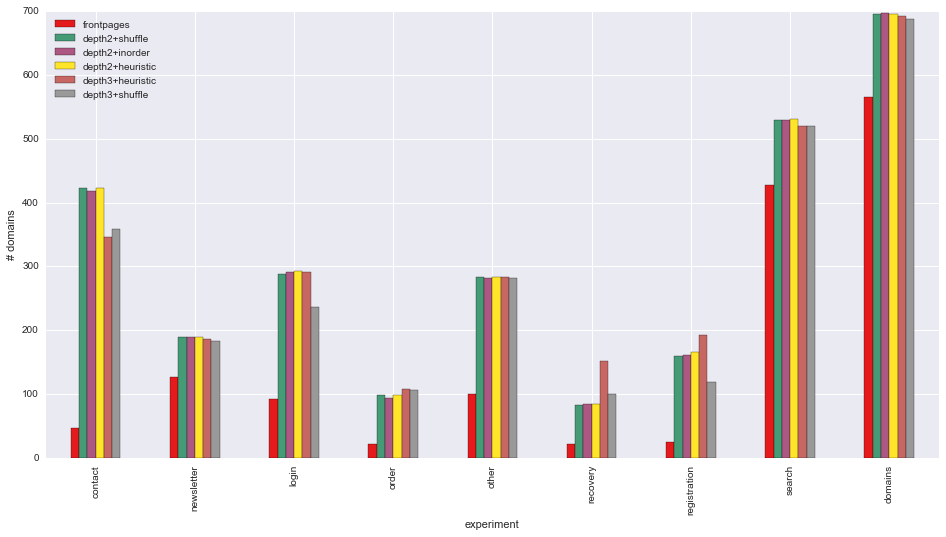

,contact,newsletter,login,order,other,recovery,registration,search,domains
frontpages,46.948606,126.606234,91.975533,20.933230,99.015207,21.002903,24.174854,428.024094,565
depth2+shuffle,423.075829,189.855971,287.570538,98.397906,283.675295,83.176447,159.635669,530.181822,696
depth2+inorder,417.462212,189.757987,291.441838,92.730266,282.336952,83.649728,160.879174,530.204738,697
depth2+heuristic,423.086432,189.844914,293.333546,98.070894,283.069977,83.665575,165.806126,530.227938,696
depth3+heuristic,346.109187,186.637195,291.122133,107.059964,282.895620,151.511778,192.722836,519.344649,692
depth3+shuffle,358.340659,182.353025,236.827404,106.779929,280.937760,100.414312,118.223464,519.699393,688


In [23]:
experiment_names = [name for path, name in experiments]

E = pd.DataFrame(
    [get_expectation(df) for df in results], 
    index=experiment_names,
)
plot_expectations(E)
E

In [24]:
E.max(axis=0)

contact         423.086432
newsletter      189.855971
login           293.333546
order           107.059964
other           283.675295
recovery        151.511778
registration    192.722836
search          530.227938
domains         697.000000
dtype: float64

Charts above are for 50K crawl; let's check how crawlers work if they only allowed to make 5K requests (hint: much worse):

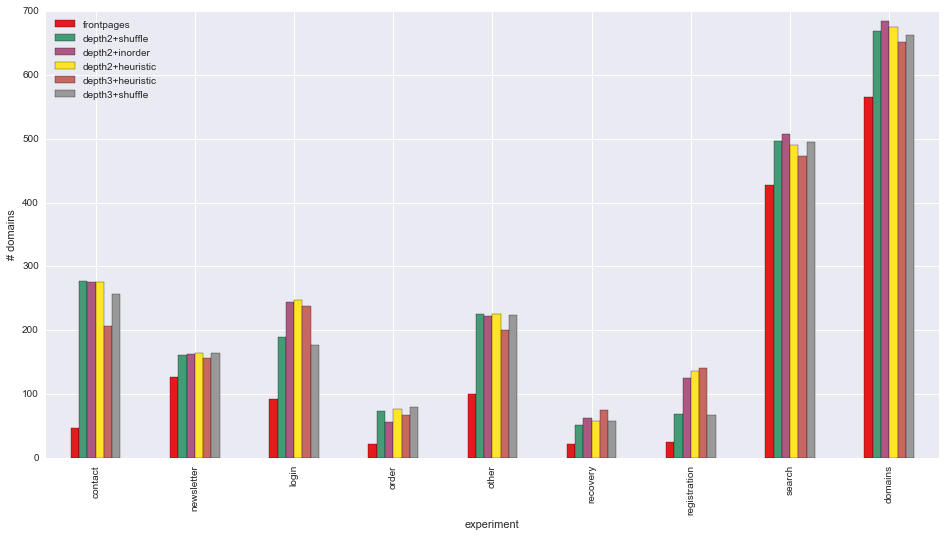

,contact,newsletter,login,order,other,recovery,registration,search,domains
frontpages,46.948606,126.606234,91.975533,20.933230,99.015207,21.002903,24.174854,428.024094,565
depth2+shuffle,276.429758,161.702969,189.858287,73.739009,226.003602,51.353687,69.034655,496.181365,669
depth2+inorder,274.718594,162.510500,243.297937,56.210566,222.552011,62.312959,124.183093,508.226507,684
depth2+heuristic,275.388125,164.501826,246.424646,76.916047,225.245810,57.569497,136.306216,490.767387,675
depth3+heuristic,206.298652,156.571471,237.139910,66.356073,200.648095,75.468218,140.150740,472.739257,652
depth3+shuffle,256.604166,163.942407,176.691212,78.935883,222.973871,56.875084,67.074356,495.176582,663


In [51]:
E = pd.DataFrame(
    [get_expectation(df[df.req_id <= 10000]) for df in results], 
    index=experiment_names
)
plot_expectations(E)
E

In [52]:
E.max(axis=0)

contact         276.429758
newsletter      164.501826
login           246.424646
order            78.935883
other           226.003602
recovery         75.468218
registration    140.150740
search          508.226507
domains         684.000000
dtype: float64

In [20]:
# for ex in experiments:
#     print("Experiment:", ex)
#     df = load_df(ex)
#     print_crawl_stats(df)
    
# plt.show()

In [1010]:
experiment = DEPTH2_HEURISTIC
pages = list(tqdm(read_jl(experiment)))

In [1011]:
df2 = pd.DataFrame(pages)
# df2['domain'] = df2.url.apply(get_domain)

In [1397]:
class_columns = ['contact', 'newsletter', 'login', 'order', 'other', 'recovery', 'registration', 'search']

def margin(row):
    a, b = sorted(row)[-2:]
    return b-a

def get_margin_column(df):
    return df[class_columns].apply(margin, axis=1)    

# df = results[3]
# df['margin'] = get_margin_column(df)
# df.sort_values('margin')[6000:]

In [ ]:
df2.hist()

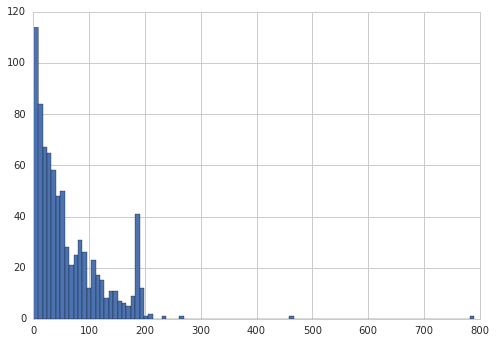

In [1185]:
df2.domain.value_counts().hist(bins=100)

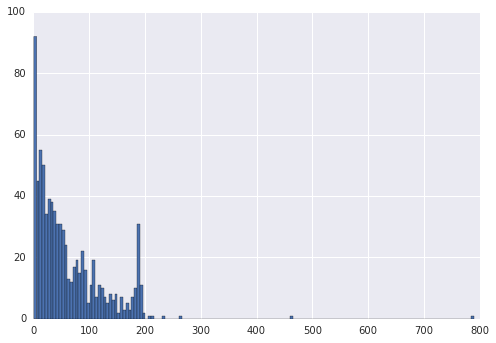

In [1137]:
vc2 = df2.domain.value_counts()
vc2.hist(bins=(vc2.max()//5))

In [1013]:
vc2.sum(), vc2[vc2 > 120].count()

(50043, 131)

In [1014]:
vc2

wordpress                   790
blogspot                    464
mitbbssg                    263
startup                     235
mediatakeout                213
jinwuzhongguo               208
photoforum                  200
lippys                      196
udans                       194
housedo                     193
activemobility              193
marketpaketi                191
2girl                       191
clicads                     191
cruiseshipschedule          191
besttrusts                  191
gameskip                    191
webarbiter                  191
kockashop                   191
tramontana                  190
theneedledrop               190
disfracesjarana             190
dailymedi                   190
kijonan                     190
trip-show                   190
karacol                     190
fightcopyrighttrolls        190
metamarket                  190
classi4au                   190
gamesatis                   190
                           ... 
xrea    

In [1015]:
%%time
df = pd.DataFrame(expand_forms(pages))
df = df.fillna(0.0)
df = df.rename(columns={
    'contact/comment': 'contact',
    'join mailing list': 'newsletter',
    'order/add to cart': 'order',
    'password/login recovery': 'recovery'
})

CPU times: user 904 ms, sys: 28.2 ms, total: 932 ms
Wall time: 939 ms


In [1016]:
# df['domain'] = df.url.apply(get_domain)

In [1017]:
vc = df.domain.value_counts()
(vc).sum()

117185

In [1117]:
df[df.req_id < 2000].domain.nunique()

518

In [1143]:
df_E = get_expectations(df, columns=['registration', 'login'])

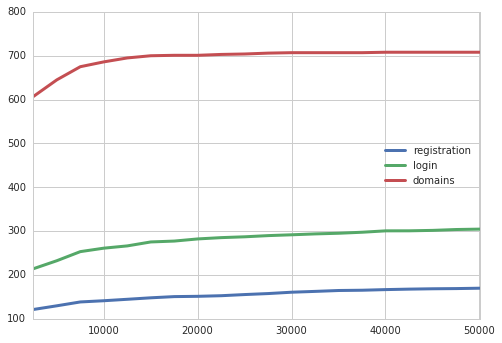

In [1147]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 3})
df_E.plot()

In [1025]:
# %%time
g = df[df.req_id < 1000].groupby('domain')
domain_max = g.max()
del domain_max['url']
del domain_max['depth']
del domain_max['req_id']
# (domain_max.registration > 0.3).sum()
domain_max.sum()

contact          34.805612
newsletter       64.976329
login            93.162493
order            11.656042
other            54.539419
recovery         17.995395
registration     46.703974
search          221.198860
dtype: float64

contact         423.646263
newsletter      190.851889
login           304.546204
order            96.843202
other           285.661045
recovery         99.821208
registration    169.765843
search          541.743093
dtype: float64

In [967]:
df3[df3.registration > 0.3]

,,contact,depth,domain,newsletter,login,order,other,recovery,registration,search,url
domain,,,,,,,,,,,,
safarinow,77,0.000028,1,safarinow,0.015868,0.001307,0.000521,0.001288,0.000178,0.980462,0.000349,http://www.safarinow.com/
citysquares,86,0.001186,2,citysquares,0.029368,0.001996,0.000083,0.000337,0.002925,0.964055,0.000050,http://citysquares.com/users/sign_up
vumedi,111,0.000090,1,vumedi,0.000350,0.000003,0.000432,0.000042,0.000403,0.998334,0.000345,https://www.vumedi.com/accounts/login/
macprovideo,183,0.000666,2,macprovideo,0.002088,0.000981,0.000929,0.011988,0.001929,0.981088,0.000332,https://www.macprovideo.com/createaccount/
vezess,188,0.000489,2,vezess,0.002628,0.000488,0.000372,0.017020,0.003183,0.974991,0.000829,http://www.vezess.hu/regisztracio/
safarinow,191,0.000028,2,safarinow,0.015868,0.001307,0.000521,0.001288,0.000178,0.980462,0.000349,http://www.safarinow.com/join
kikki-k,194,0.000075,2,kikki-k,0.000650,0.000373,0.001183,0.002075,0.000209,0.992679,0.002756,https://www.kikki-k.com/customer/account/login/
clienttrack,260,0.082609,1,clienttrack,0.066213,0.000489,0.109198,0.041113,0.033035,0.369036,0.298307,http://clienttrack.com/
wicktory,267,0.000278,1,wicktory,0.000978,0.001406,0.001529,0.010202,0.011081,0.973449,0.001079,http://wicktory.co.za


In [952]:
df[(df.registration > 0.3)].domain.describe()

count          1288
unique          180
top       ingliando
freq            153
Name: domain, dtype: object

In [929]:
df.domain.describe()

count               103612
unique                 709
top       12gebrauchtwagen
freq                  8112
Name: domain, dtype: object

In [930]:
df.depth.value_counts()

2    102413
1      1199
Name: depth, dtype: int64

In [897]:
columns = ['registration', 'login', 'contact', 'other', 'search', 'recovery', 'newsletter', 'order']
(df[columns] > 0.3).sum()

registration     2912
login           11443
contact         12785
other           30015
search          51181
recovery         3437
newsletter      10218
order            2978
dtype: int64

In [898]:
form_counts = [len(p['forms']) for p in pages]

In [899]:
Counter(form_counts)

Counter({0: 8286,
         1: 14328,
         2: 10690,
         3: 7243,
         4: 3674,
         5: 1464,
         6: 567,
         7: 570,
         8: 1363,
         9: 611,
         10: 769,
         11: 24,
         12: 137,
         13: 60,
         14: 16,
         15: 27,
         16: 19,
         17: 9,
         18: 7,
         19: 2,
         20: 4,
         21: 8,
         22: 5,
         23: 8,
         24: 2,
         25: 17,
         27: 2,
         28: 4,
         29: 5,
         31: 7,
         32: 3,
         33: 16,
         34: 1,
         35: 7,
         37: 2,
         39: 4,
         41: 5,
         42: 1,
         43: 6,
         45: 8,
         46: 1,
         47: 3,
         49: 2,
         51: 19,
         53: 3,
         54: 1,
         55: 3,
         57: 1,
         58: 1,
         59: 7,
         61: 2,
         63: 1,
         65: 2,
         67: 5,
         75: 1,
         76: 1,
         77: 1,
         97: 1,
         103: 2,
         145: 1})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1545a27b8>]], dtype=object)

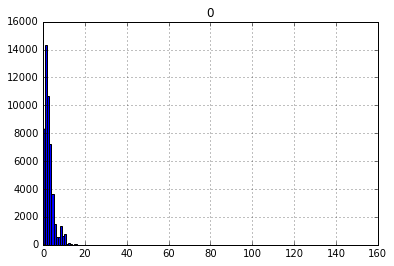

In [900]:
pd.DataFrame(form_counts).hist(bins=max(form_counts))